# **S&P500 Forecasting using LSTM**

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')


# Download data: SPY and other indicators
def download_data():
    tickers = ['SPY', 'AAPL', 'XLF', 'QQQ','VXX','DIA']
    data = yf.download(tickers, start='2020-01-01', end='2024-01-01')['Close']
    return data


[*********************100%***********************]  6 of 6 completed


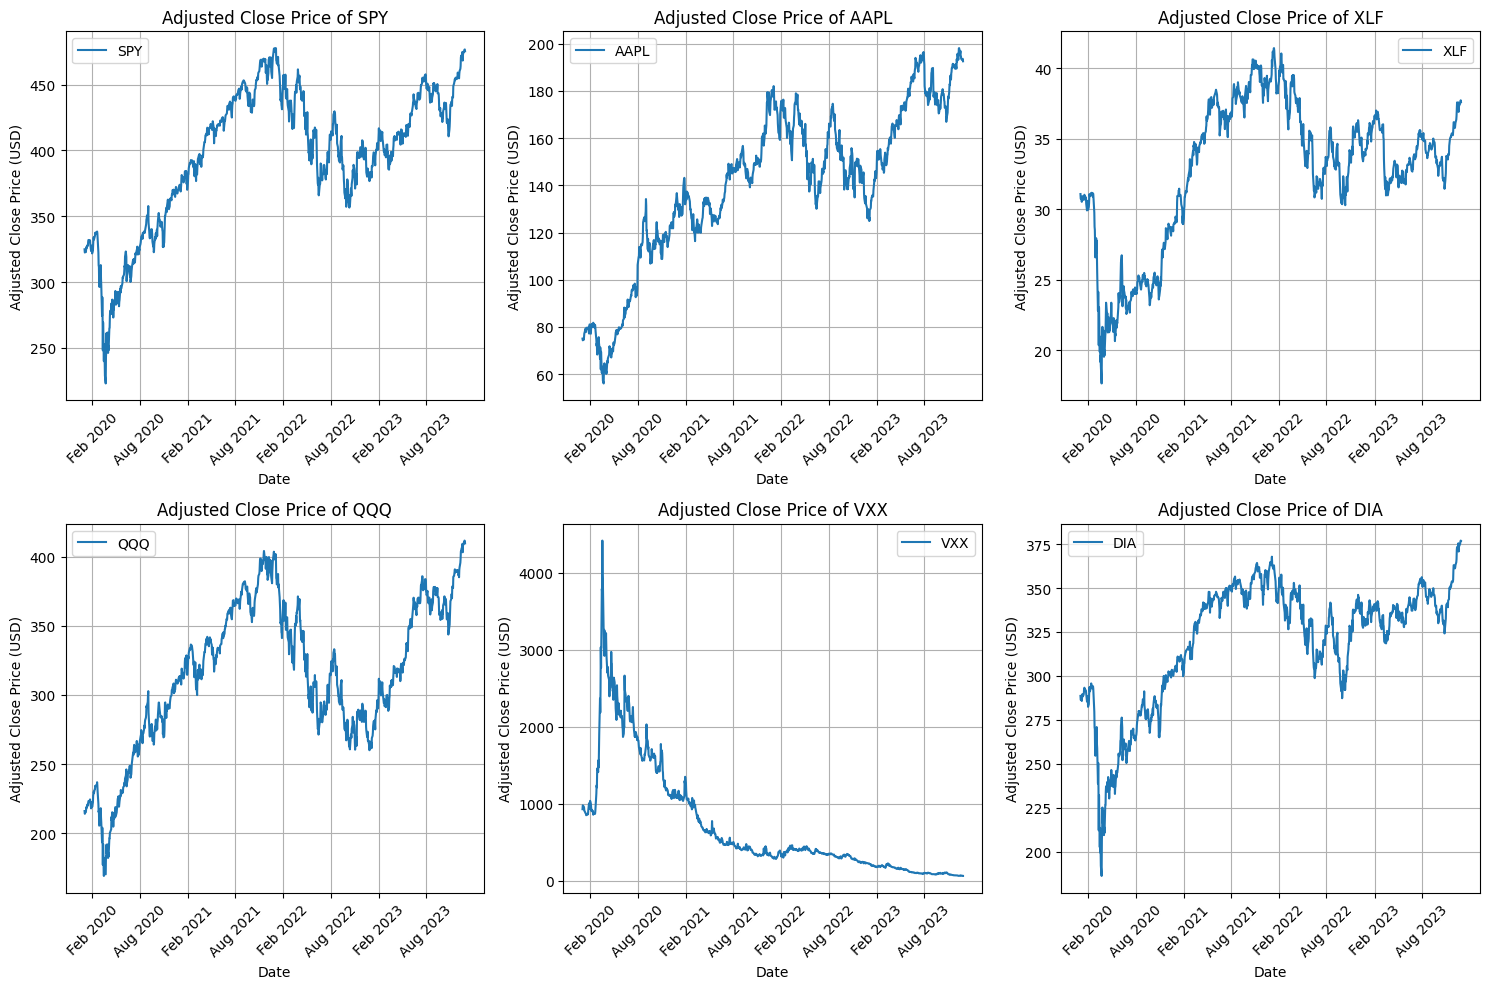

In [2]:
data = download_data()

tickers = ['SPY', 'AAPL', 'XLF', 'QQQ','VXX','DIA']
num_tickers = len(tickers)

num_cols = 3
num_rows = int(np.ceil(num_tickers / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, ticker in enumerate(tickers):
    axes[i].plot(data.index, data[ticker], label=ticker)
    axes[i].set_title(f'Adjusted Close Price of {ticker}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Adjusted Close Price (USD)')
    axes[i].legend()
    axes[i].grid(True)

    # Custom x-ticks: show only Jan and July of each year
    custom_ticks = pd.date_range(start=data.index.min(), end=data.index.max(), freq='6MS')
    axes[i].set_xticks(custom_ticks)
    axes[i].set_xticklabels(custom_ticks.strftime('%b %Y'), rotation=45)

# Remove any unused axes
for j in range(num_tickers, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


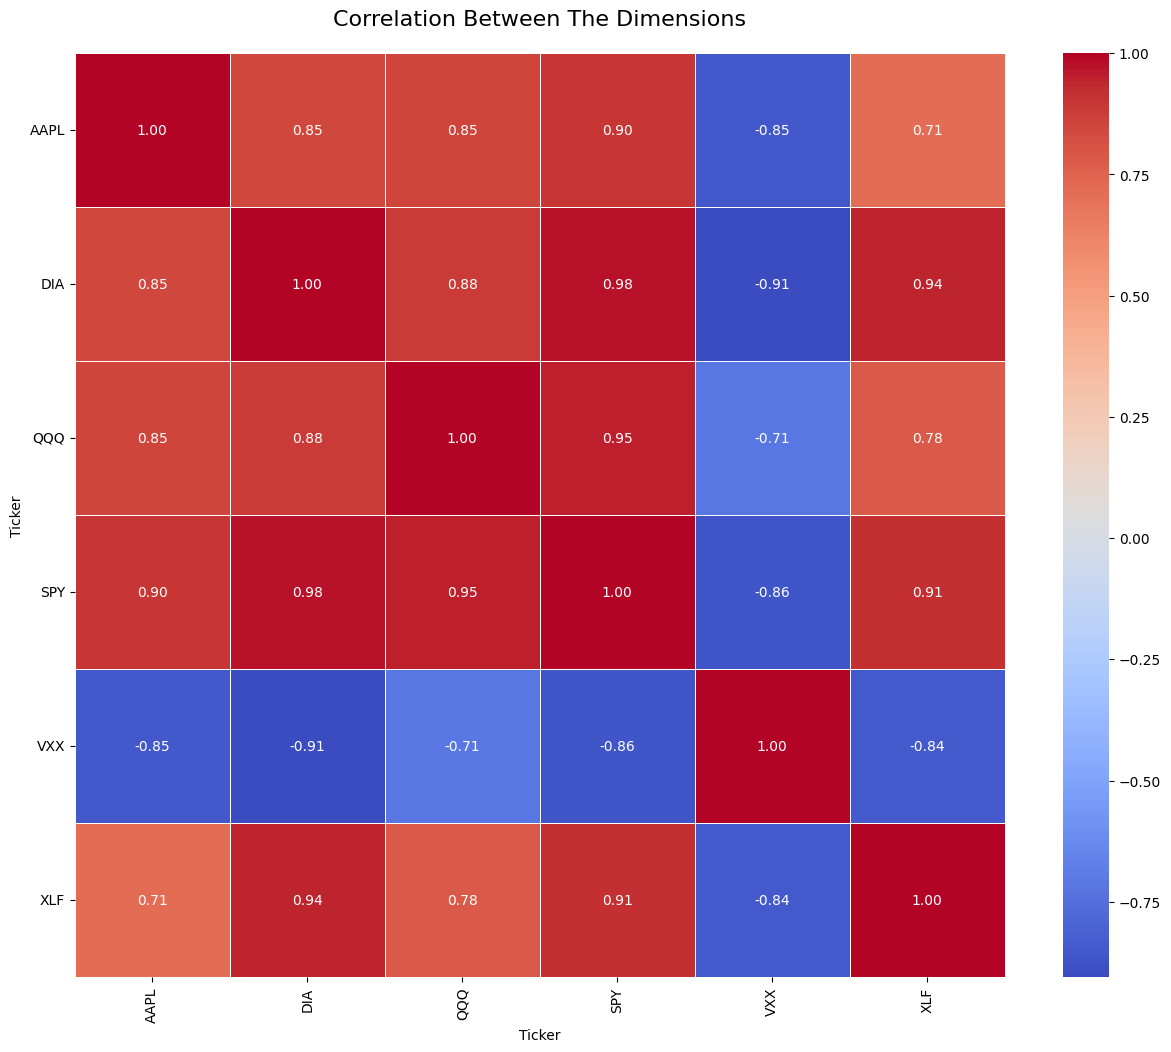

In [3]:
def plot_correlation_heatmap(df, title="Correlation Between The Dimensions"):
    plt.figure(figsize=(15, 12))
    sns.heatmap(
        df.corr(),
        annot=True,
        fmt='.2f',
        linewidths=0.5,
        cmap='coolwarm',
        annot_kws={"size": 10}
    )
    plt.title(title, fontsize=16, pad=20)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

plot_correlation_heatmap(data)


In [4]:
# Feature engineering:
def feature_engineering(data):
    # SPY-specific features (MA10, MA50, RSI)
    data['SPY_MA10'] = data['SPY'].rolling(window=10).mean()
    data['SPY_MA50'] = data['SPY'].rolling(window=50).mean()
    data['SPY_RSI'] = 100 - (100 / (1 + (data['SPY'].diff().apply(lambda x: x if x > 0 else 0).rolling(14).mean() /
                                    data['SPY'].diff().apply(lambda x: abs(x)).rolling(14).mean())))
    data.dropna(inplace=True)
    return data
data=feature_engineering(data)
data.head(10)

Ticker,AAPL,DIA,QQQ,SPY,VXX,XLF,SPY_MA10,SPY_MA50,SPY_RSI
Date,,,,,,,,,
2020-03-13 00:00:00+00:00,69.492500,232.110001,192.339996,269.320007,2764.800049,23.049999,287.654997,319.262002,25.822192
2020-03-16 00:00:00+00:00,60.552502,202.490005,169.300003,239.850006,3789.439941,19.889999,280.730998,317.561602,23.830037
2020-03-17 00:00:00+00:00,63.215000,213.470001,182.139999,252.800003,3744.639893,20.969999,275.987000,316.169402,26.347732
2020-03-18 00:00:00+00:00,61.667500,199.389999,176.600006,240.000000,4416.000000,19.190001,268.701001,314.496602,26.460147
2020-03-19 00:00:00+00:00,61.195000,201.309998,177.660004,240.509995,3968.000000,19.610001,262.506001,312.852202,26.664989
2020-03-20 00:00:00+00:00,57.310001,191.899994,170.699997,228.800003,3875.199951,18.910000,255.640002,310.939202,23.223662
2020-03-23 00:00:00+00:00,56.092499,186.130005,170.460007,222.949997,3272.320068,17.660000,250.512001,308.865202,23.489856
2020-03-24 00:00:00+00:00,61.720001,206.639999,183.660004,243.149994,3017.600098,19.850000,245.984999,307.214002,24.941313
2020-03-25 00:00:00+00:00,61.380001,212.059998,182.300003,246.789993,3257.600098,20.389999,243.228000,305.590801,26.555137


Training with learning rate: 0.001 and batch size: 32
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
RMSE for this configuration: 10.927358627741036
Training with learning rate: 0.001 and batch size: 16
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
RMSE for this configuration: 7.084490626452491
Training with learning rate: 0.01 and batch size: 32


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step
RMSE for this configuration: 11.766587987571418
Training with learning rate: 0.01 and batch size: 16
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
RMSE for this configuration: 8.110289965973632
Best RMSE: 7.084490626452491


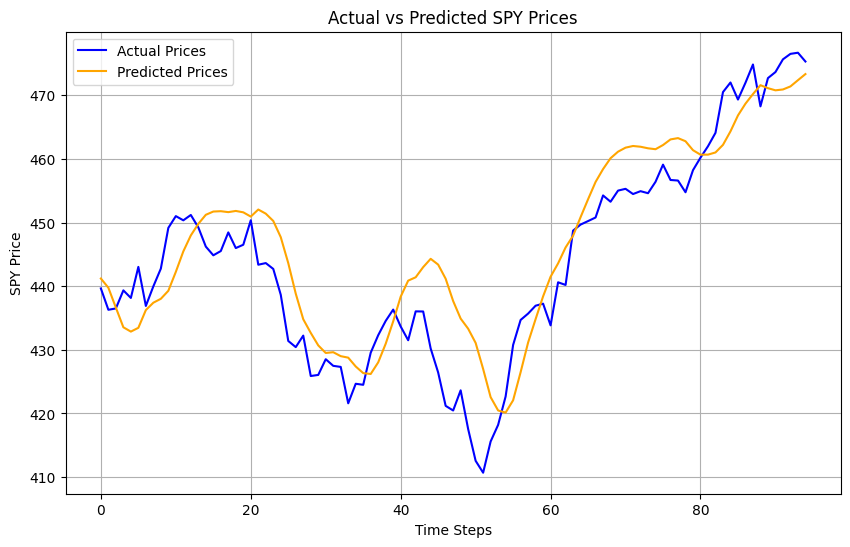

In [5]:
#pre-process the data
def prepare_data(data, window_size=10):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i-window_size:i])
        y.append(scaled_data[i, 0])  # SPY column is first after scaling
    return np.array(X), np.array(y), scaler


# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=3,
    restore_best_weights=True
)

# LSTM Model Function
def build_lstm(input_shape, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

X, y, scaler = prepare_data(data[['SPY', 'AAPL', 'XLF', 'QQQ', 'VXX', 'DIA', 'SPY_MA10', 'SPY_MA50', 'SPY_RSI']])

# Split data into training and testing sets
split_idx = int(len(X) * 0.9)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Hyperparameters for fine-tuning
learning_rates = [0.001, 0.01]
batch_sizes = [32, 16]

best_rmse = float('inf')
best_model = None

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training with learning rate: {lr} and batch size: {batch_size}")
        model = build_lstm((X_train.shape[1], X_train.shape[2]), learning_rate=lr)
        history = model.fit(
            X_train, y_train,
            validation_split=0.15,
            epochs=25,
            batch_size=batch_size,
            verbose=0,
            callbacks=[early_stopping]
        )
        predictions = model.predict(X_test)
        predictions = scaler.inverse_transform(
            np.hstack((predictions, np.zeros((predictions.shape[0], X_test.shape[2] - 1)))))[:, 0]
        y_test_rescaled = scaler.inverse_transform(
            np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1)))))[:, 0]
        rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions))
        print(f"RMSE for this configuration: {rmse}")
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_predictions = predictions
            best_y_test_rescaled = y_test_rescaled

print(f"Best RMSE: {best_rmse}")

# Plot Actual vs Predicted Prices
def plot_predicted_vs_actual(y_test_rescaled, predictions):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_rescaled, label='Actual Prices', color='blue')
    plt.plot(predictions, label='Predicted Prices', color='orange')
    plt.title('Actual vs Predicted SPY Prices')
    plt.xlabel('Time Steps')
    plt.ylabel('SPY Price')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_predicted_vs_actual(best_y_test_rescaled, best_predictions)


# **Forecast the next 4 days**

In [6]:

model=best_model
# Forecast the next 4 days using the last window in X_test
def forecast_next_4_days(model, X_test, scaler):
    last_window = X_test[-1]
    forecasts = []

    for _ in range(4):
        prediction = model.predict(last_window[np.newaxis, :, :])[0, 0]
        forecasts.append(prediction)
        new_input = np.append(last_window[1:, :], [[prediction] * last_window.shape[1]], axis=0)
        last_window = new_input

    forecasts = np.array(forecasts).reshape(-1, 1)

    # Reverse the scaling
    scaled_forecasts = scaler.inverse_transform(
        np.hstack((forecasts, np.zeros((forecasts.shape[0], X_test.shape[2] - 1)))))[:, 0]

    return scaled_forecasts

# Predict the next 4 days
next_4_days_predictions = forecast_next_4_days(model, X_test, scaler)

# Fetch the next 4 days of actual SPY data
actual_next_4_days = yf.download('SPY', start='2024-01-02', end='2024-01-06')['Close'].values.flatten()

# Calculate RMSE for the next 4 days
rmse = np.sqrt(mean_squared_error(actual_next_4_days, next_4_days_predictions))
print("")
print(f"RMSE for the next 4 days: {rmse}")

# Display results
print("Predicted Next 4 Days:", next_4_days_predictions)
print("Actual Next 4 Days:", actual_next_4_days)

df_comparison = pd.DataFrame({
    'Date': pd.date_range(start='2024-01-02', periods=4, freq='D'),
    'Actual SPY': actual_next_4_days,
    'Predicted SPY': next_4_days_predictions
})
df_comparison


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[*********************100%***********************]  1 of 1 completed


RMSE for the next 4 days: 2.851512998701629
Predicted Next 4 Days: [473.33378012 472.75758924 471.20671548 468.86666084]
Actual Next 4 Days: [472.6499939  468.79000854 467.27999878 467.92001343]


,Date,Actual SPY,Predicted SPY
0,2024-01-02,472.649994,473.333780
1,2024-01-03,468.790009,472.757589
2,2024-01-04,467.279999,471.206715
3,2024-01-05,467.920013,468.866661
